The code is based on the paper:
Towards Simulating Foggy and Hazy Images and Evaluating Their Authenticity.
Referenced Github: https://github.com/noahzn/FoHIS

MiDAS is based on the paper: Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer
Referenced Github: https://github.com/isl-org/MiDaS

In [1]:
import torch
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from noise import pnoise3

In [2]:
# Visibility range of molecules in meters
molecule_visibility = 12
# Visibility range of aerosols in meters
aerosol_visibility = 450
# Coefficients
ECM = 3.912 / molecule_visibility
ECA = 3.912 / aerosol_visibility
# FOG_TOP m
FT = 70
# HAZE_TOP m
HT = 34
# These parameters are set based for road-scenes based images
CAMERA_ALTITUDE = 1.6
fov = 64

In [3]:
img = "Shift-Dataset/Images/image_2959-26d8_00000000_img_front.jpg"
Ip = cv2.imread(img)

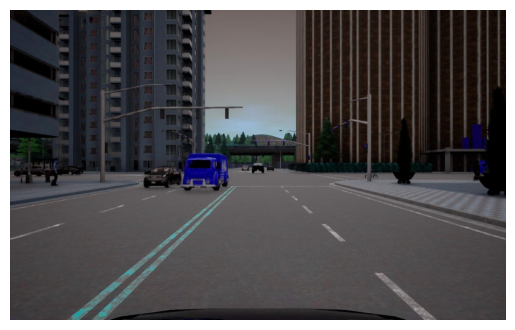

In [4]:
plt.imshow(cv2.cvtColor(Ip, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [5]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("mps") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

Using cache found in /Users/abhinandp/.cache/torch/hub/intel-isl_MiDaS_master


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [6]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/abhinandp/.cache/torch/hub/intel-isl_MiDaS_master


In [7]:
img_d = cv2.imread(img)
img_d = cv2.cvtColor(img_d, cv2.COLOR_BGR2RGB)
input_batch = transform(img_d).to(device)

In [8]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_d.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output_d = prediction.cpu().numpy()

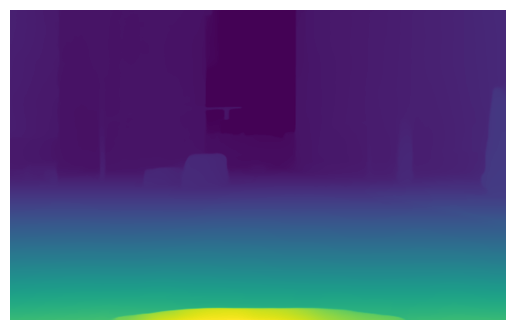

In [9]:
plt.imshow(output_d)
plt.axis('off')
plt.show()

In [10]:
cv2.imwrite('img/result_d.jpg', output_d)

True

In [11]:
depth = cv2.imread('img/result_d.jpg')[:, :, 0].astype(np.float64)
depth[depth==0] = 1
depth *= 3

In [12]:
I = np.empty_like(Ip)
result = np.empty_like(Ip)

In [13]:
def get_image_info(src):
    im = Image.open(src)
    try:
        dpi = im.info['dpi']
    except KeyError:
        dpi = (72, 72)
    return dpi

In [14]:
def elevation_and_distance_estimation(src, depth, vertical_fov, camera_altitude):
    # Load the image and get its DPI
    img = cv2.imread(src)
    img_dpi = get_image_info(src)

    height, width = img.shape[:2]
    altitude = np.empty((height, width))
    distance = np.empty((height, width))
    angle = np.empty((height, width))
    depth_min = depth.min()

    for j in range(width):
        for i in range(height):
            # theta is the vertical angle
            theta = i / (height - 1) * vertical_fov

            # Case: theta is less than half of the vertical FOV
            if theta < 0.5 * vertical_fov:
                distance[i, j] = depth[i, j] / math.cos(math.radians(0.5 * vertical_fov - theta))
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (0.5*height-i)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = camera_altitude+depth[i, j]*y1/depth_min
                angle[i, j] = 0.5 * vertical_fov - theta
            # Case: theta is half of the vertical FOV
            elif theta == 0.5 * vertical_fov:
                distance[i, j] = depth[i, j]
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (i-0.5*height)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = max(camera_altitude - depth[i, j]*y1/depth_min, 0)
                angle[i, j] = 0
            # Case: theta is greater than half of the vertical FOV
            elif theta > 0.5 * vertical_fov:
                distance[i, j] = depth[i, j] / math.cos(math.radians(theta-0.5*vertical_fov))
                h_half = math.tan(0.5*vertical_fov)*depth_min
                y2 = (i-0.5*height)/img_dpi[0]*2.56
                y1 = h_half*y2/(height/img_dpi[0]*2.56)
                altitude[i, j] = max(camera_altitude - depth[i, j]*y1/depth_min, 0)
                angle[i, j] = -(theta - 0.5 * vertical_fov)
    return altitude, distance, angle

In [15]:
elevation, distance, angle = elevation_and_distance_estimation(img, depth, fov, CAMERA_ALTITUDE)

In [16]:
def noise(Ip, depth):
    # Initialize three grayscale images
    p1 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    p2 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    p3 = Image.new('L', (Ip.shape[1], Ip.shape[0]))
    # Define scales for noise generation
    scales = [1/130.0, 1/60.0, 1/10.0]
    # Generate noise
    for i, scale in enumerate(scales):
        for y in range(Ip.shape[0]):
            for x in range(Ip.shape[1]):
                # Generate Perlin noise
                v = pnoise3(x * scale, y * scale, depth[y, x] * scale, octaves=1, persistence=0.5, lacunarity=2.0)
                color = int((v + (1.2 if i == 2 else (0.5 if i == 1 else 1)))*128)
                if i == 0:
                    p1.putpixel((x, y), color)
                elif i == 1:
                    p2.putpixel((x, y), color)
                elif i == 2:
                    p3.putpixel((x, y), color)
    # Final perlin noise
    perlin = (np.array(p1) + np.array(p2) / 2 + np.array(p3) / 4) / 3
    return perlin

In [17]:
perlin = noise(Ip, depth)
c = (1-elevation/(FT+0.00001))
c[c<0] = 0
ECM = (ECM * c + (1-c)*ECA) * (perlin/255)

In [18]:
distance_through_fog = np.zeros_like(distance)
distance_through_haze = np.zeros_like(distance)
distance_through_haze_free = np.zeros_like(distance)

In [19]:
idx1 = (np.logical_and(FT > elevation, elevation > HT))
idx2 = elevation <= HT
idx3 = elevation >= FT

distance_through_haze[idx2] = distance[idx2]
distance_through_fog[idx1] = (elevation[idx1] - HT) * distance[idx1] / (elevation[idx1] - CAMERA_ALTITUDE)
distance_through_haze[idx1] = distance[idx1] - distance_through_fog[idx1]
distance_through_haze[idx3] = (HT - CAMERA_ALTITUDE) * distance[idx3] / (elevation[idx3] - CAMERA_ALTITUDE)
distance_through_fog[idx3] = (FT - HT) * distance[idx3] / (elevation[idx3] - CAMERA_ALTITUDE)
distance_through_haze_free[idx3] = distance[idx3] - distance_through_haze[idx3] - distance_through_fog[idx3]

I[:, :, 0] = Ip[:, :, 0] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
I[:, :, 1] = Ip[:, :, 1] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
I[:, :, 2] = Ip[:, :, 2] * np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)
O = 1-np.exp(-ECA*distance_through_haze-ECM*distance_through_fog)

In [20]:
Ial = np.empty_like(Ip)
Ial[:, :, 0] = 225
Ial[:, :, 1] = 225
Ial[:, :, 2] = 201

In [21]:
result[:, :, 0] = I[:, :, 0] + O * Ial[:, :, 0]
result[:, :, 1] = I[:, :, 1] + O * Ial[:, :, 1]
result[:, :, 2] = I[:, :, 2] + O * Ial[:, :, 2]

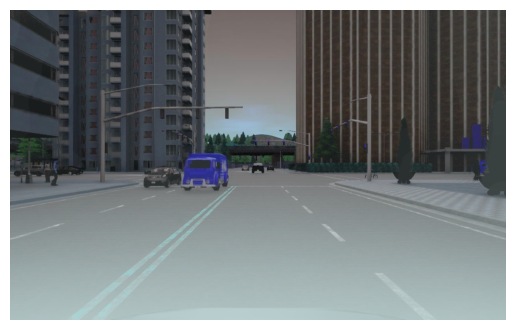

In [22]:
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [23]:
cv2.imwrite('Results/With_MiDaS/result.jpg', result)

True